# Семинар 11 - Кластеризация

In [3]:
import math 
from math import floor
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# %matplotlib inline
# plt.style.use('seaborn')

seed = 42
np.random.seed(seed)

D:\Anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<a id="Content"></a>
# Содержание
0. [Подготовка данных](#0)
   - [Вспомогательная функция оценки сегментации](#0.1)
1. [Алгоритмы кластеризации](#1)
   - [Agglomerative](#1.1)
   - [Mean-Shift](#1.2)
   - [DBSCAN](#1.3)
2. [Визуализация данных](#2)
   - [Подготовим данные](#2.1)
   - [PCA](#2.2)
   - [KMeans](#2.3)
   - [t-SNE Method (T-Distributed Stochastic Neighbor Embedding)](#2.4)
   - [KMeans w/ TSNE](#2.5)
   - [DBScan on TSNE Cluster Analysis](#2.6)
3. [Оценка важности признаков](#3)
   - [Feature importance](#3.1)
4. [Полезные ссылки](#4)

<a id="0"></a>
# 0. Подготовка данных

In [4]:
from sklearn.datasets import make_blobs, make_moons

In [5]:
centers = [[1, 1], [-1, -1], [1, -1], [2, 3]]
blobs = make_blobs(n_samples=750, centers=centers, cluster_std=1.5, random_state=seed) 
# noisy_moons = make_moons(n_samples=750, noise=0.05, random_state=seed)

X, y = blobs
X = StandardScaler().fit_transform(X)

In [6]:
# # Generate sample data
# n_samples = 1500
# np.random.seed(0)
# t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
# x = t * np.cos(t)
# y = t * np.sin(t)


# X = np.concatenate((x, y))
# X += 0.7 * np.random.randn(2, n_samples)
# X = X.T

In [7]:
def plot_xy_set(X, labels):
    unique_labels = set(labels)

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = X[class_member_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=4,
        )

    plt.title("Estimated number of clusters: %d" % len(unique_labels))

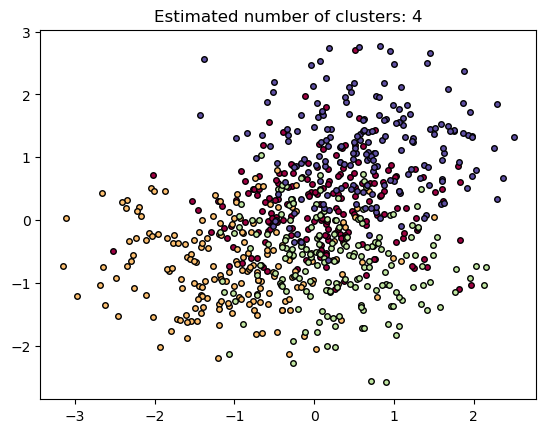

In [8]:
plot_xy_set(X, y)

<a id="0.1"></a>
## 0.1. Вспомогательная функция оценки сегментации

In [9]:
from sklearn import metrics

In [10]:
def log_calc_metrics(y_true, y_pred):
    # Однородность (Homogeneity) измеряет, насколько каждый кластер содержит объекты только одного класса. 
    # Высокая однородность означает, что все объекты в кластере принадлежат одному и тому же классу.
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_true, y_pred)) 

    # Полнота (Completeness) измеряет, насколько все объекты одного класса находятся в одном кластере. 
    # Высокая полнота означает, что все объекты одного класса находятся в одном кластере.
    print("Completeness: %0.3f" % metrics.completeness_score(y_true, y_pred))

    # V-мера является гармоническим средним однородности и полноты. 
    # Она учитывает как однородность, так и полноту, предоставляя более сбалансированную оценку качества кластеризации.
    print("V-measure: %0.3f" % metrics.v_measure_score(y_true, y_pred))

    # Скорректированный индекс Рэнда (Adjusted Rand Index) измеряет согласованность между двумя разбиениями, учитывая случайное совпадение.
    print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y_true, y_pred))

    # Скорректированная взаимная информация (Adjusted Mutual Information) измеряет количество информации, общий для двух разбиений, с коррекцией на случайное совпадение. 
    # Она корректирует взаимную информацию для случайных разбиений.
    print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y_true, y_pred))

<a id="1"></a>
# 1. Алгоритмы кластеризации

<a id="1.1"></a>
## 1.1. Agglomerative

In [11]:
# Compute clustering
print("Compute structured hierarchical clustering...")
n_clusters = 5  # number of regions
ward = AgglomerativeClustering(n_clusters=n_clusters,
        linkage='ward', distance_threshold=None).fit(X)

label = ward.labels_
print("Number of frames: ", label.size)
print("Number of clusters: ", np.unique(label).size)

log_calc_metrics(y, label)

Compute structured hierarchical clustering...
Number of frames:  750
Number of clusters:  5
Homogeneity: 0.329
Completeness: 0.288
V-measure: 0.307
Adjusted Rand Index: 0.253
Adjusted Mutual Information: 0.304


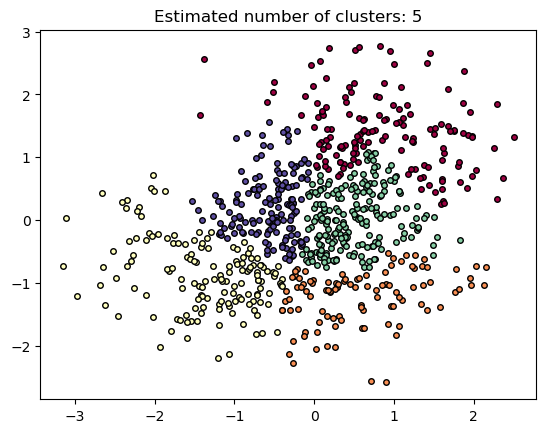

In [12]:
plot_xy_set(X, label)

<a id="1.2"></a>
## 1.2. Mean-Shift 

In [13]:
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.05, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
print("Number of frames: ", label.size)
print("Number of clusters: ", np.unique(label).size)

log_calc_metrics(y, label)

Number of frames:  750
Number of clusters:  5
Homogeneity: 0.329
Completeness: 0.288
V-measure: 0.307
Adjusted Rand Index: 0.253
Adjusted Mutual Information: 0.304


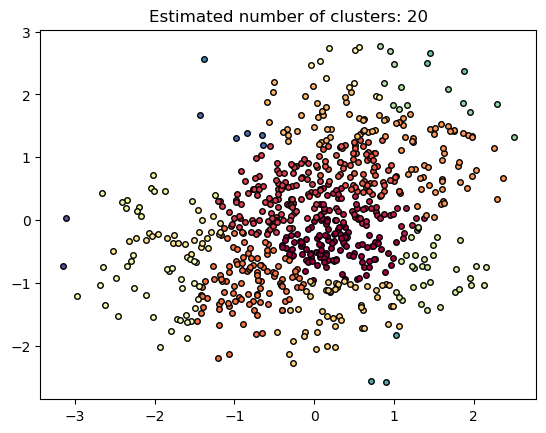

In [14]:
plot_xy_set(X, labels)

<a id="1.3"></a>
## 1.3. DBSCAN 

In [15]:
# Compute DBSCAN
db = DBSCAN(eps=0.05, min_samples=4).fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
label = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Number of clusters: %d" % n_clusters_)
print("Number of noise points: %d" % n_noise_)

log_calc_metrics(y, label)

Number of clusters: 20
Number of noise points: 0
Homogeneity: 0.028
Completeness: 0.090
V-measure: 0.042
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.012


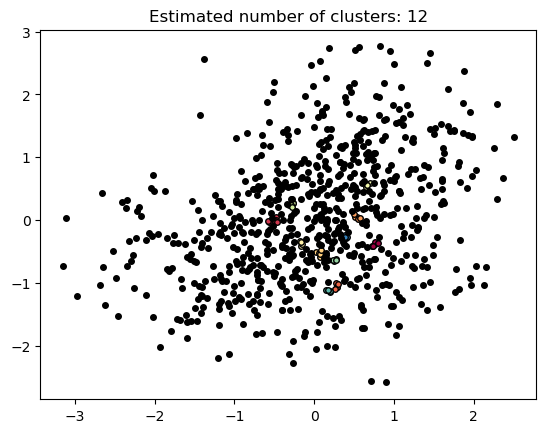

In [16]:
plot_xy_set(X, label)

<a id="2"></a>
# 2. Визуализация данных

<a id="2.1"></a>
## 2.1. Подготовим данные

In [17]:
data = pd.read_csv('covid_stat.csv')

In [18]:
data.head(5).T

,0,1,2,3,4
Country/Region,United States,India,Brazil,United Kingdom,Russia
Deaths,755636,461389,609573,142293,243405
Cases,46613141,34377113,21886077,9379286,8689818
Country Code,USA,IND,BRA,GBR,RUS
Population,322941311,1324509589,206163058,65611593,144342396
Cases3dayAvg,59058.0,10810.0,7873.0,30889.333333,38831.666667
Cases7dayAvg,73235.0,11553.714286,10197.714286,34120.714286,38930.428571
Cases14dayAvg,73435.285714,12493.642857,10751.214286,37727.285714,38562.285714
Deaths3dayAvg,570.0,374.666667,171.0,91.333333,1154.0
Deaths7dayAvg,1148.428571,358.428571,235.857143,170.714286,1155.285714


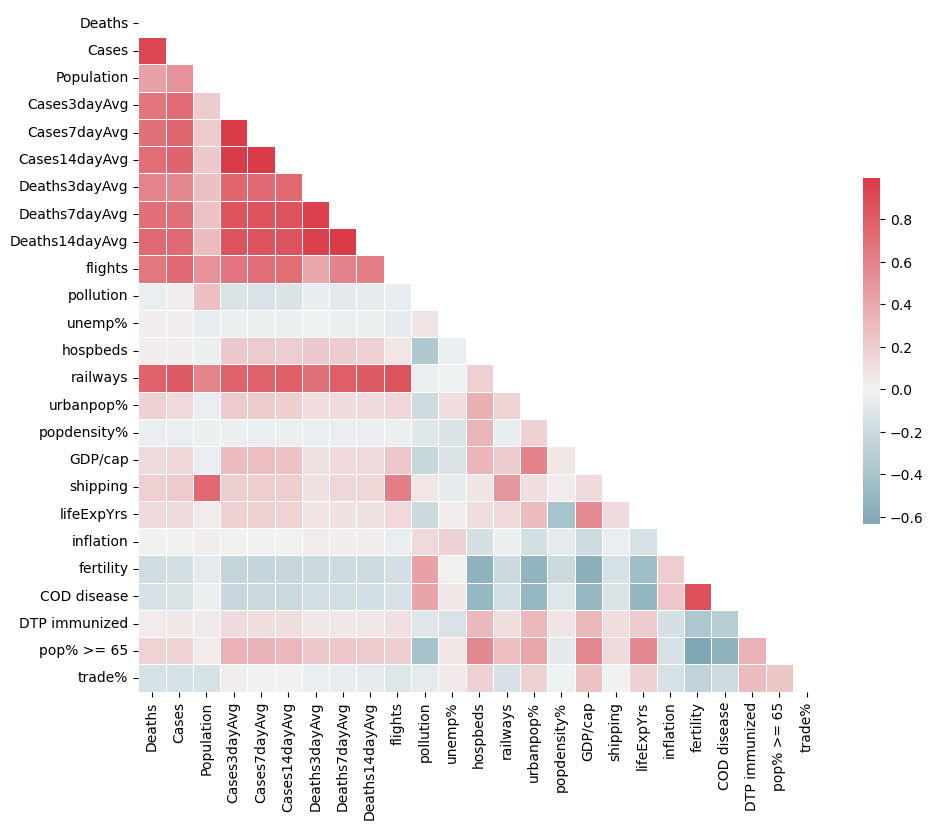

In [19]:
df_corr = data.corr(numeric_only=True)

mask = np.triu(np.ones_like(df_corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [20]:
scaler = StandardScaler()

df_orig = data.copy().set_index('Country/Region').drop(columns=['Country Code'])
df_sc = pd.DataFrame(scaler.fit_transform(df_orig), index=df_orig.index, columns=df_orig.columns)

display('original', data.head(2), 'scaled', df_sc.head(2))

'original'

,Country/Region,Deaths,Cases,Country Code,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
0,United States,755636,46613141,USA,322941311,59058.0,73235.000000,73435.285714,570.000000,1148.428571,...,35.89,65279.53,55518880.0,78.79,1.81,1.7,5.30,94.0,16.21,19.65
1,India,461389,34377113,IND,1324509589,10810.0,11553.714286,12493.642857,374.666667,358.428571,...,459.58,6994.03,17053200.0,69.66,3.72,2.2,24.17,91.0,6.38,28.23


'scaled'

,Deaths,Cases,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg,flights,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,,,,
United States,8.099874,9.270103,1.880101,8.412764,9.080671,9.164784,4.624783,7.779953,8.010332,11.241082,...,-0.181694,2.034616,2.634567,0.644284,-0.240958,-0.741497,-0.749301,0.419211,1.143501,-1.102094
India,4.819993,6.759215,8.552563,1.260806,1.153728,1.289977,2.942259,2.235049,2.840929,1.130772,...,0.084192,-0.631766,0.655495,-0.197263,-0.025744,-0.345730,0.229012,0.245499,-0.332676,-0.871696


<a id="2.2"></a>
## 2.2. PCA

In [21]:
plotX = df_sc.copy()

pca = PCA(n_components='mle', random_state=seed)
principalComponents = pca.fit_transform(plotX)
PCA_components = pd.DataFrame(principalComponents, index=plotX.index)

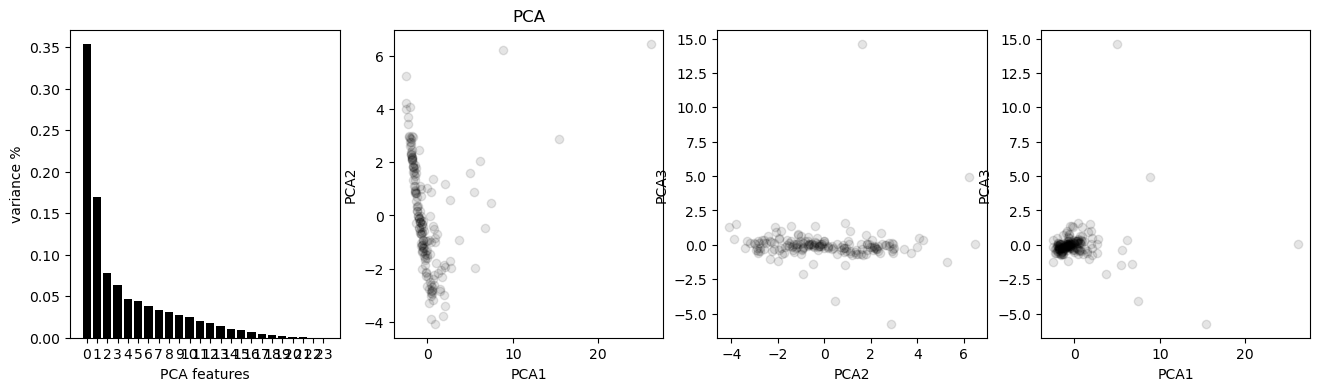

In [22]:
# Plot the explained variances
features = range(pca.n_components_)

fig,ax = plt.subplots(1,4, figsize=(16,4))

ax[0].bar(features, pca.explained_variance_ratio_, color='black')
ax[0].set(xlabel='PCA features')
ax[0].set(ylabel='variance %')
ax[0].set(xticks=features)

ax[1].scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
ax[1].set(xlabel='PCA1')
ax[1].set(ylabel='PCA2')
ax[1].set(title='PCA')

ax[2].scatter(PCA_components[1], PCA_components[2], alpha=.1, color='black')
ax[2].set(xlabel='PCA2')
ax[2].set(ylabel='PCA3')

ax[3].scatter(PCA_components[0], PCA_components[2], alpha=.1, color='black')
ax[3].set(xlabel='PCA1')
ax[3].set(ylabel='PCA3')

plt.show()

<a id="2.3"></a>
## 2.3. KMeans

Алгоритм KMeans группирует данные, пытаясь разделить выборки на n групп с равной дисперсией, минимизируя критерий, известный как **инерция** или внутрикластерная сумма квадратов:

$$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$$

In [23]:
def elbow_check(df_km):
    ks = range(1, 10)
    inertias = []
    for k in ks:
        model = KMeans(n_clusters=k)
        model.fit(df_km.iloc[:, :3])
        inertias.append(model.inertia_)

    plt.plot(ks, inertias, '-o', color='black')
    plt.title('inertia - sum dist^2 of centroid to samples')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()

In [24]:
import warnings
warnings.filterwarnings("ignore")

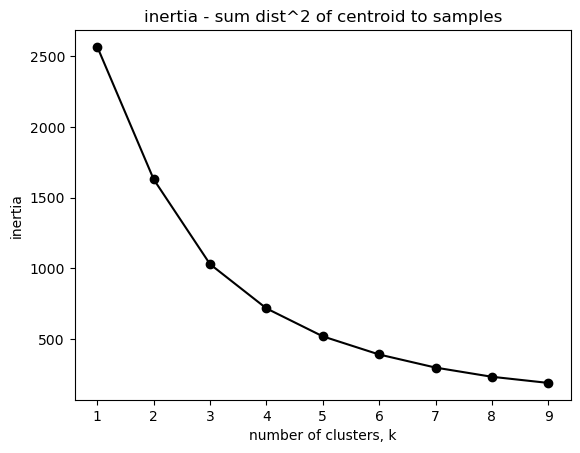

In [25]:
elbow_check(PCA_components)

In [26]:
def plot_clusters(cluster_name, cluster_cases, df_comp, dims=2):
    fig,ax = plt.subplots(1, len(cluster_cases), figsize=(16,4))

    for c, clusters in enumerate(cluster_cases):
        model = KMeans(n_clusters=clusters)
        df_comp2 = df_comp.copy()
        m = model.fit(df_comp2)
        df_comp2.insert(0, 'cluster', m.labels_)

        datas = []
        for i in range(clusters): 
            tup = []
            for j in range(dims):  ## should be cluster dims? pca dims?
                tup.append(df_comp2[df_comp2['cluster'] == i][j])
            datas.append(tup)

        groups = [cluster_name+str(i) for i in range(clusters)]
        colors = ('green','red','blue','yellow','purple','brown')

        for data,color,group in zip(datas,colors,groups):
            x,y = data[0],data[1]
            ax[c].scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=100, label=group)
            ax[c].set_title(f'{cluster_name} Kmeans {clusters} clusters')
            ax[c].set(xlabel=cluster_name+'1')
            ax[c].set(ylabel=cluster_name+'2')
    plt.show()

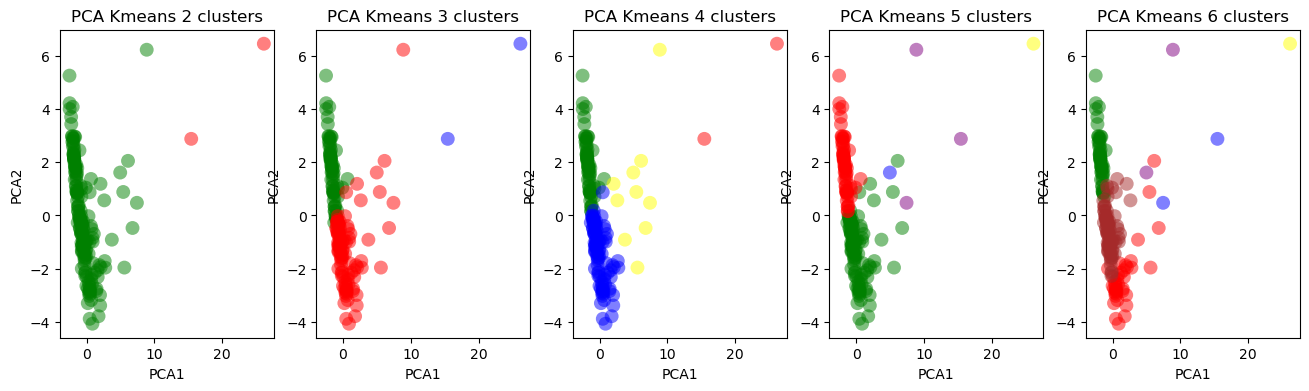

In [27]:
cluster_cases = [2, 3, 4, 5, 6]

plot_clusters('PCA', cluster_cases, PCA_components)

In [44]:
def plot_big(clustering_name, reducer_name, model, df_comp, df, dims=2, countries=30):
    df_comp2 = df_comp.copy()
    fig, ax = plt.subplots(figsize=(16, 12))

    m = model.fit(df_comp2)  # first 3 cols, or dims
    df_comp2.insert(0, 'cluster', m.labels_)
    
    datas = []
    for i in range(len(set(m.labels_))):
        tup = []
        for j in range(dims):
            tup.append(df_comp2[df_comp2['cluster']==i][j])
        datas.append(tup)

    groups = [clustering_name+str(i) for i in range(len(set(m.labels_)))]
    colors = ('green','red','yellow','cyan','purple','brown')

    for data,color,group in zip(datas,colors,groups):
        x,y = data[0],data[1]
        ax.scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax.set_title(f'{reducer_name} {clustering_name} {len(set(m.labels_))} clusters')
        ax.set(xlabel=f'{reducer_name}1')
        ax.set(ylabel=f'{reducer_name}2')

    for index, row in df_comp2[df_comp2.index.isin(['United Kingdom','Belgium','Canada', 'France', 'Germany', 'Italy', 'Netherlands', 'Sweden', 'Switzerland','Canada','Japan','United States','China','Australia','Singapore','South Africa','Belarus','Brazil','Russia','India','Poland'])].iterrows():
        ax.annotate(index, (row[0], row[1]))
    for index, row in df_comp2.sample(countries).iterrows():
        ax.annotate(df.iloc[index].name, (row[0], row[1]))

    plt.legend(loc=1)
    plt.show()

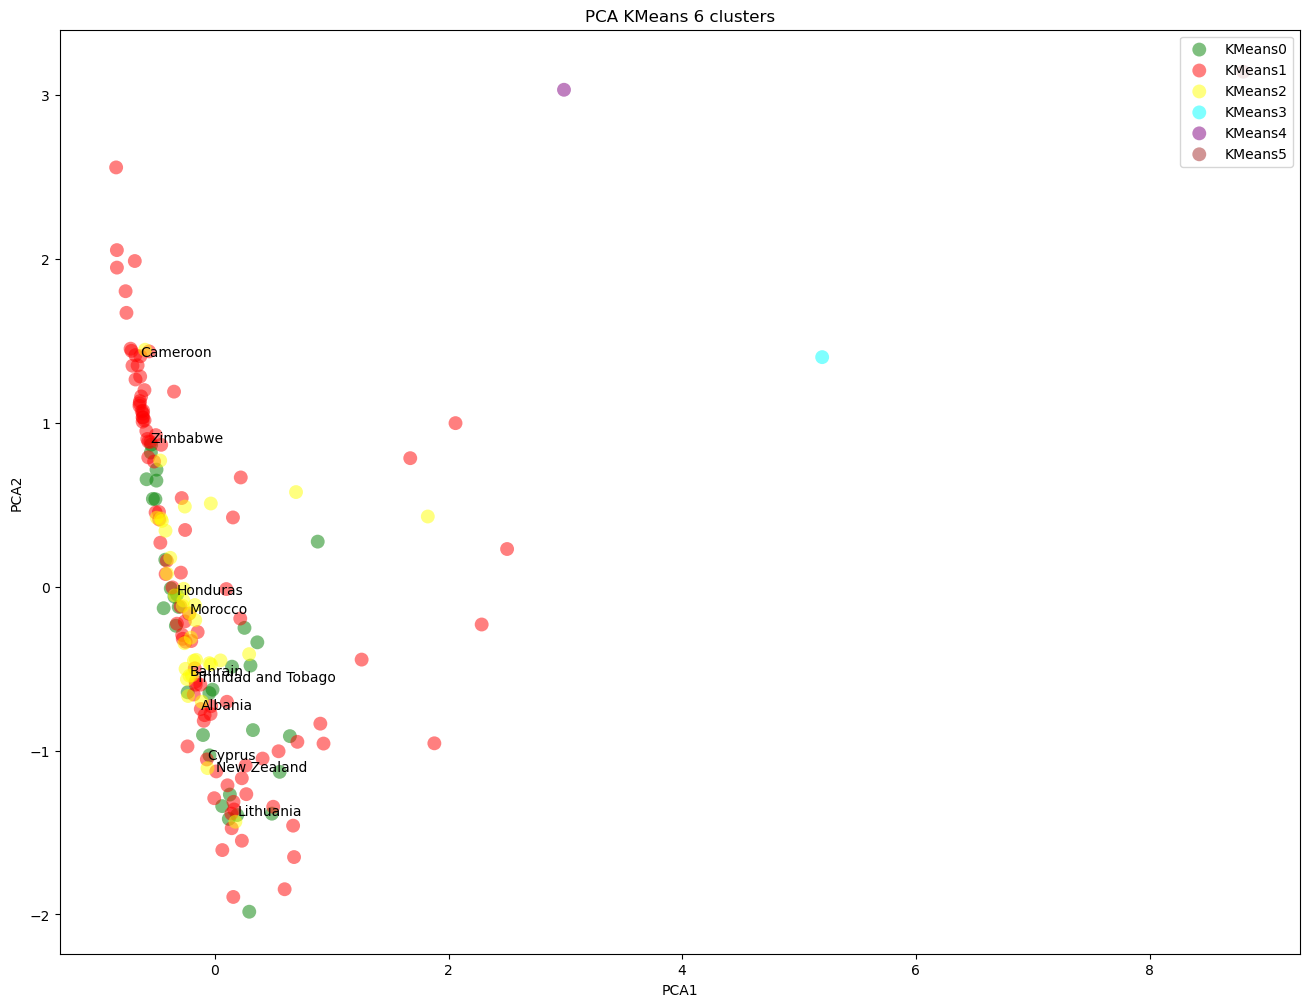

In [45]:
model = KMeans(n_clusters=6, random_state=seed)
# model = DBSCAN(eps=0.3, min_samples=1)
PCA_scale = StandardScaler().fit_transform(PCA_components)
PCA_scale = pd.DataFrame(PCA_scale, columns=PCA_components.columns)
plot_big('KMeans','PCA', model, PCA_scale, df_sc, countries=10)

<a id="2.4"></a>)
## 243. t-SNE Method (T-Distributed Stochastic Neighbor Embedding)

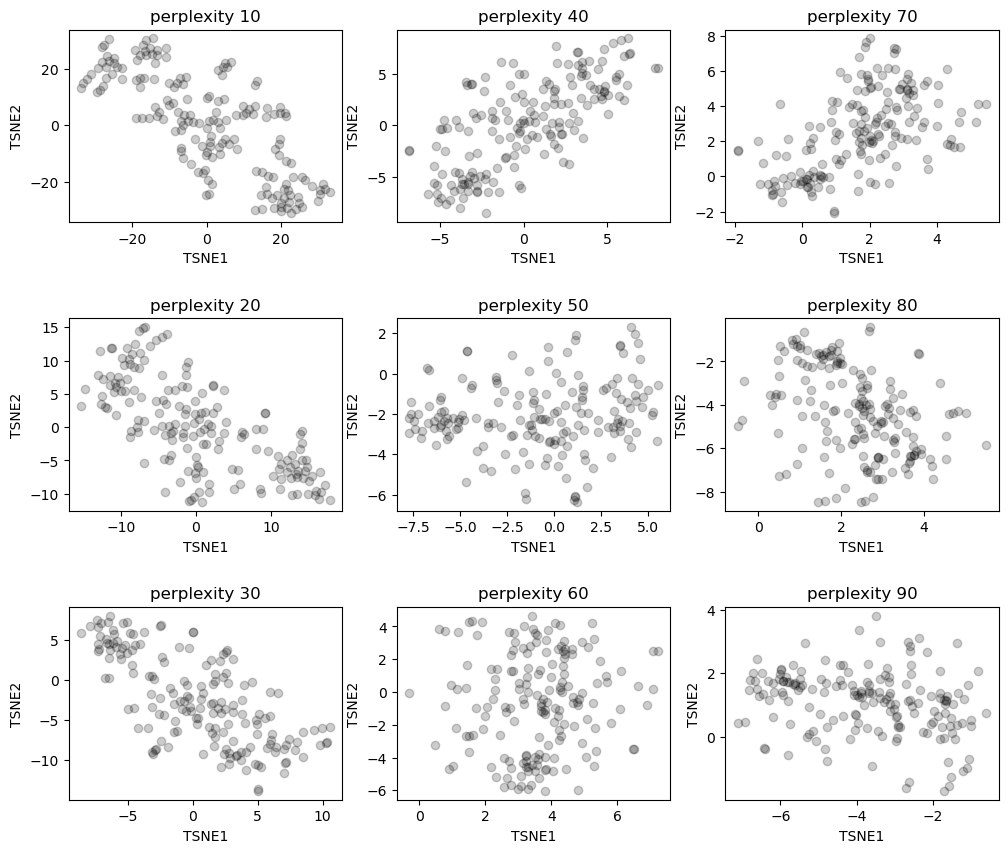

In [33]:
plotX = df_sc.copy()
ps = np.linspace(10, 90, 9).astype(int)

fig,ax = plt.subplots(3, 3, figsize=(12,10))
plt.subplots_adjust(hspace=.5)

for i, perplexity in enumerate(ps):
    tsne = TSNE(n_components=2, perplexity=perplexity)
    tsneComponents = tsne.fit_transform(plotX)
    TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)

    ax[i%3][math.floor(i/3)].set_title(f'perplexity {perplexity}')
    ax[i%3][math.floor(i/3)].scatter(TSNE_components[0], TSNE_components[1], alpha=.2, color='black')
    ax[i%3][math.floor(i/3)].set(xlabel='TSNE1')
    ax[i%3][math.floor(i/3)].set(ylabel='TSNE2')

In [47]:
# Fixing TSNE HyperParams (Perplexity and Comps)
tsne = TSNE(n_components=2, perplexity=20, early_exaggeration=10, random_state=seed)
tsneComponents = tsne.fit_transform(plotX)
TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)
TSNE_components.head()

,0,1
Country/Region,,
United States,-5.167759,20.131243
India,-9.677470,1.379041
Brazil,-8.863362,1.471397
United Kingdom,-2.617511,18.309402
Russia,-5.249553,19.190590


<a id="2.5"></a>
## 2.5. KMeans w/ TSNE

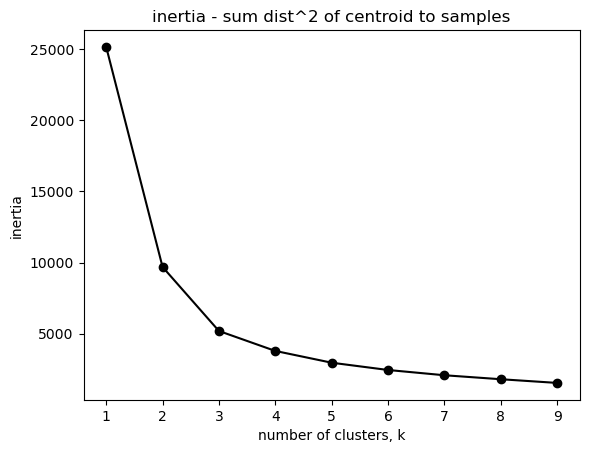

In [35]:
elbow_check(TSNE_components)

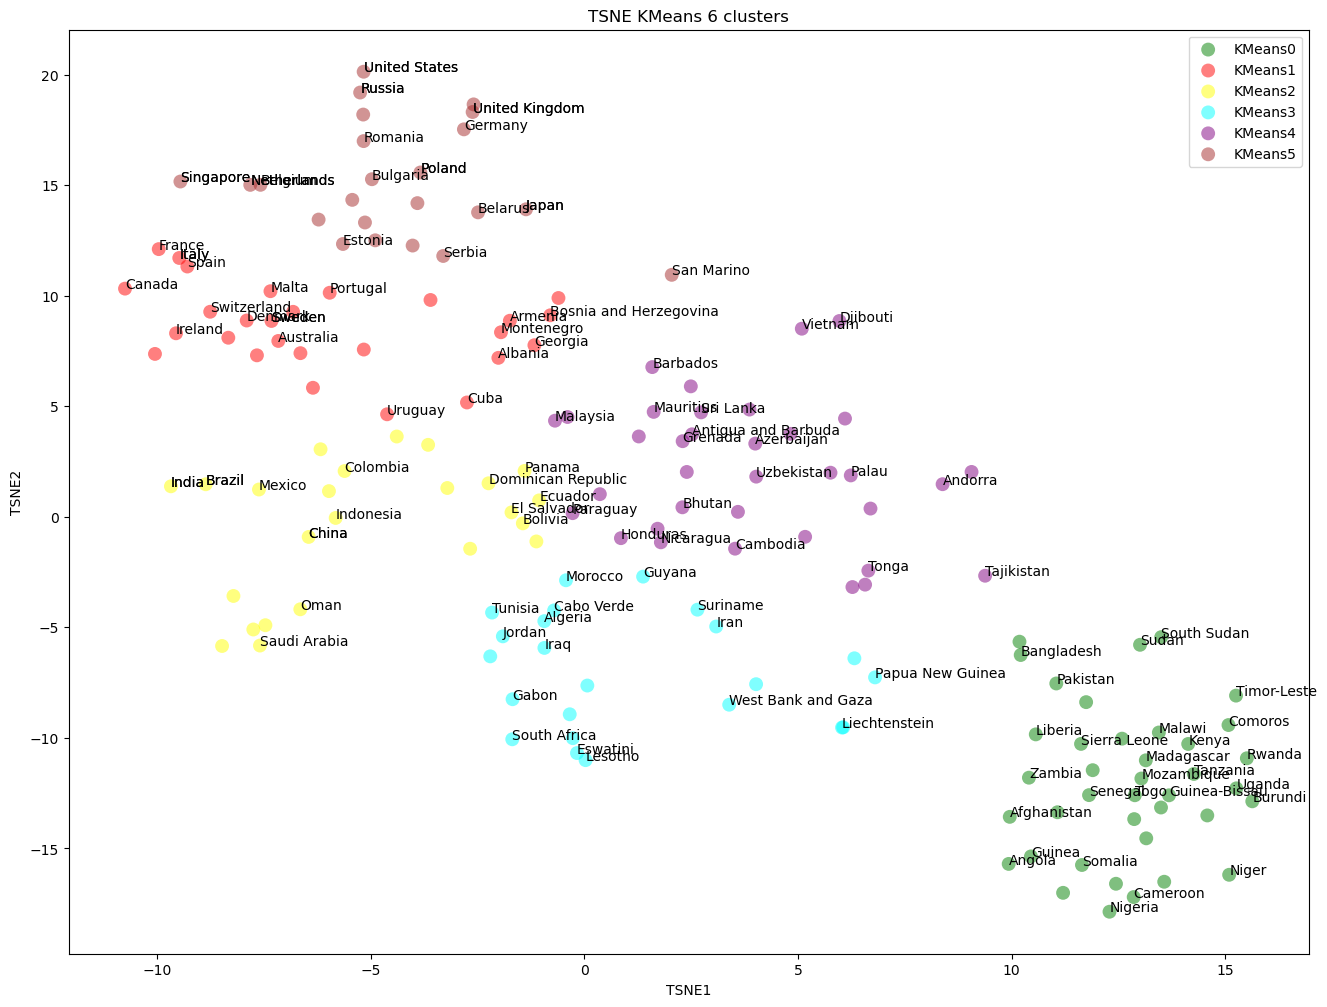

In [36]:
model = KMeans(n_clusters=6, random_state=seed)            
plot_big('KMeans','TSNE', model, TSNE_components, countries=100)

<a id="2.6"></a>
## 2.6. DBScan on TSNE Cluster Analysis

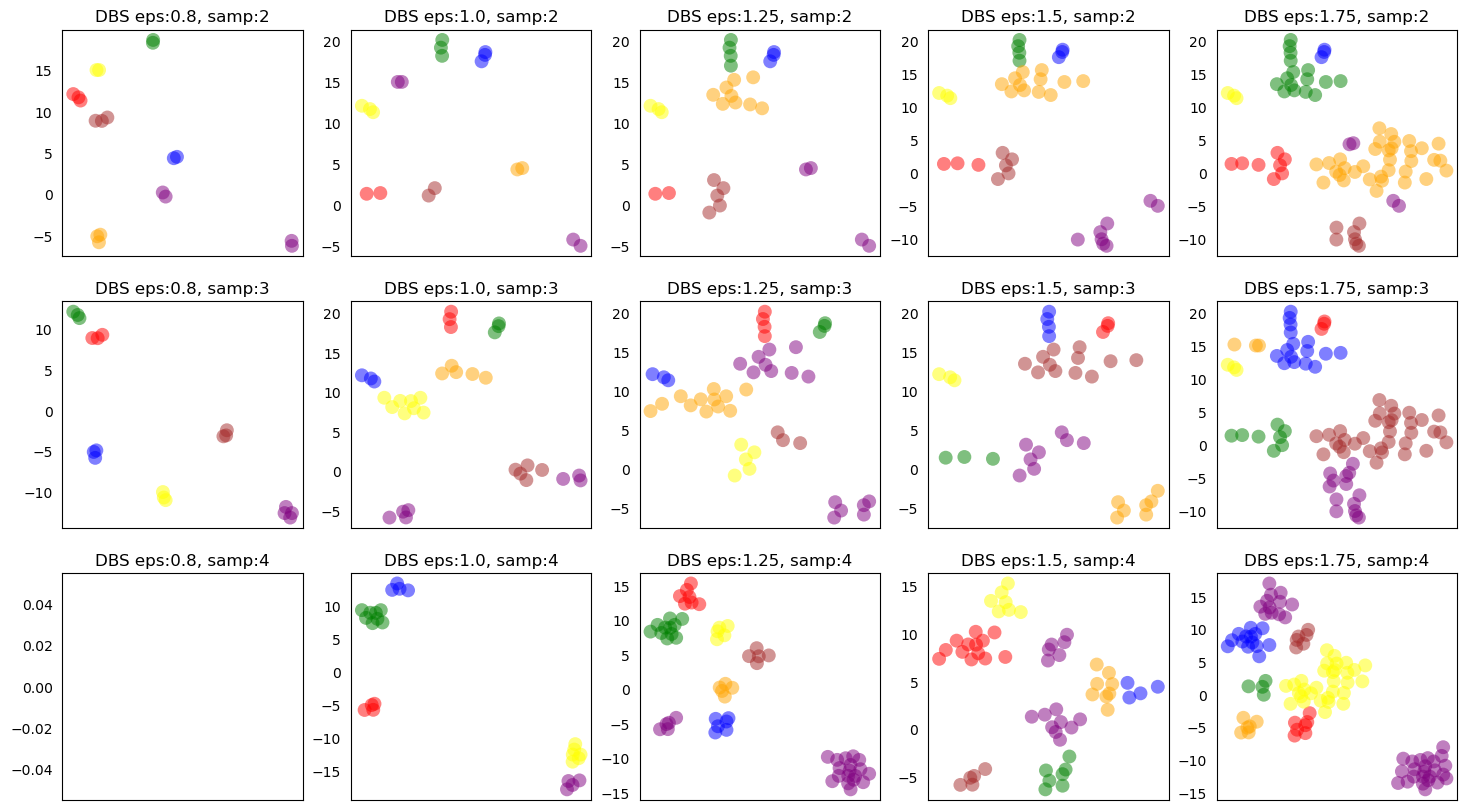

In [37]:
samp_list = [2, 3, 4]
eps_list = [0.8, 1.0, 1.25, 1.5, 1.75]
rows = len(samp_list)

fig, ax = plt.subplots(len(samp_list), len(eps_list), figsize=(18, 10))

for k, (eps, samp) in enumerate(product(eps_list, samp_list)):
    ax[k%rows][floor(k/rows)].tick_params(axis='both',which='both',bottom=False,top=False,left=False,labelbottom=False) 

    # fit t-SNE
    TSNE_df = TSNE_components.copy()
    clustering = DBSCAN(eps=eps, min_samples=samp).fit(TSNE_df)
    TSNE_df.insert(0, 'cluster', clustering.labels_)

    # plot predict
    datas = [[TSNE_df[TSNE_df['cluster']==i][j] for j in range(2)] for i in range(len(set(clustering.labels_)))]
    colors = ('green','red','blue','yellow','purple','brown','orange','purple')
    groups = [str(i) for i in range(len(set(clustering.labels_)))]

    for data,color,group in zip(datas,colors,groups):
        ax[k%rows][floor(k/rows)].scatter(data[0],data[1], alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax[k%rows][floor(k/rows)].set_title(f'DBS eps:{eps}, samp:{samp}')

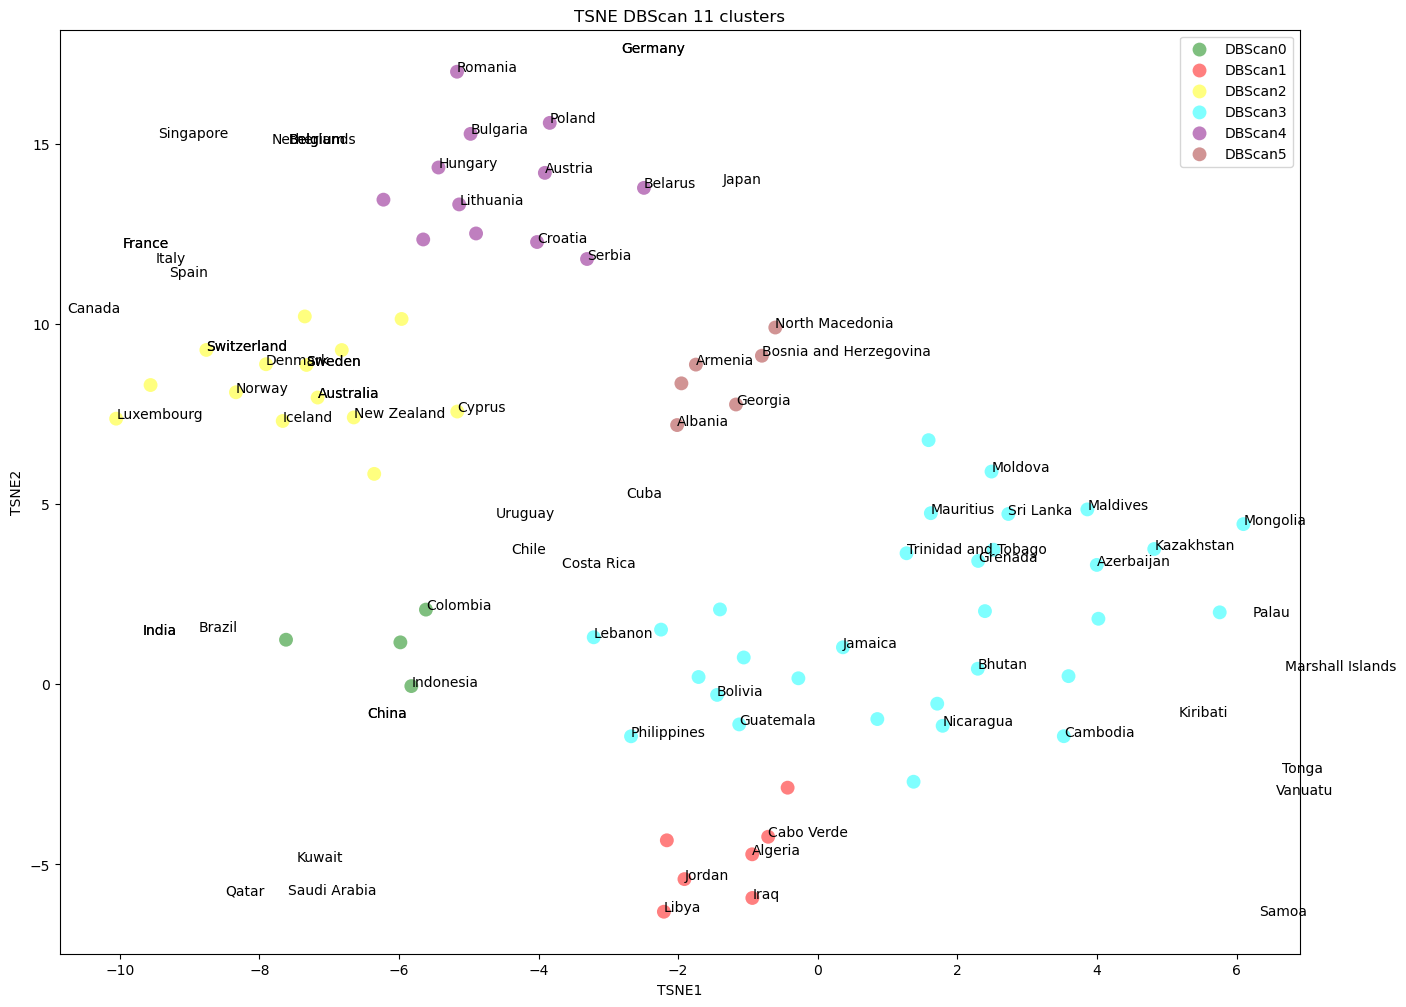

In [38]:
TSNE_df = TSNE_components.copy()
clustering = DBSCAN(eps=1.75, min_samples=4).fit(TSNE_df)
plot_big('DBScan','TSNE', clustering, TSNE_df, countries=100)

<a id="3"></a>
# 3. Оценка важности признаков 


![pipeline](pipeline.png)

In [1]:
# обучите модель понижения размерности

# Ваш код ...

In [2]:
# сделайте кластеризацию

# Ваш код ...

<a id="3.1"></a>
## 3.1. Feature importance

In [3]:
# обучите модель классификации

# Ваш код ...

In [4]:
# нарисуйте важность признаков

# Ваш код ...

# 4. Полезные ссылки
1. [KMeans](https://www.youtube.com/watch?v=4b5d3muPQmA&ab_channel=StatQuestwithJoshStarmer)
2. [t-SNE](https://www.youtube.com/watch?v=NEaUSP4YerM&ab_channel=StatQuestwithJoshStarmer)